# Curve collapse of the Binder cumulant

In this example code, we will do a curve collapse analysis of the 3-state Potts model using a radial basis function to parameterize the scaling function of the Binder cumulant $U_{4}$ and connected susceptibility $\chi$. Let's start with the Binder cumulant, defined as

$$U_{4}(K,N_{\mathrm{s}})=\frac{1}{2}\Bigg[3-\frac{\langle M^{4} \rangle}{\langle M^{2} \rangle^2}\Bigg],$$

where $M$ is the magnetization of the 3-state Potts model, $K$ is the inverse temperature, and $N_{\mathrm{s}}$ is the linear extent of the 2-dimensional lattice that we performed our simulation on. The anomalous dimension of the Binder cumulant is zero and the phase transition of the 2-state Potts model is 2nd-order. Therefore, within the vicinity of the transition temperature $K_{\mathrm{c}}$,

$$U_{4}(K,N_{\mathrm{s}})=\mathcal{F}_{U_{4}}\Big((K/K_{\mathrm{c}}-1)N_{\mathrm{s}}^{1/\nu}\Big),$$

where $\mathcal{F}_{U_{4}}$ is the universal scaling function of the Binder cumulant. Let's first import everything that we need to do the analysis.

In [32]:
""" External modules """
import gvar as gv # Peter Lepage's GVar module
import numpy as np # NumPy for number crunching

""" Local modules """
import example_tools # For getting example data

""" SwissFit modules """
from swissfit import fit # SwissFit fitter module
from swissfit.optimizers import scipy_basin_hopping # Basin hopping global optimizer
from swissfit.optimizers import scipy_least_squares # Trust region reflective local optimizer
from swissfit.machine_learning import radial_basis # Module for radial basis function network
from swissfit.empirical_bayes import single_parameter_surrogate # Empirical Bayes optimizer

Next, let's grab the data that we need over the range of temperatures $K_{\mathrm{l}}<K<K_{\mathrm{h}}$ and volumes that we wish to grab it at.

In [42]:
Kl, Kh = 1. / 0.99497, 1. / 0.982 # K = J/T, where T is the standard Ising temp.
volumes = ['64', '96', '128', '196', '256', '512'] # Ns values
data, starting_parameters = example_tools.potts3_data('u', Kl, Kh, volumes)

The variable `data` is a dictionary. The `x` key contains input $(K,N_{\mathrm{s}})$ values and the `y` key contains GVar variables for $U_{4}(K,N_{\mathrm{s}})$. The `starting_parameters` variable is also a dictionary. It contains the starting parameters that we will use to initialize our first fit in the empirical Bayes analysis. 

Now that we have our data, let's create a radial basis function network (RBFN) object. First, we need to specify the topology of the radial basis function network. We'll create a network with a single hidden layer than possesses 2 nodes in its hidden layer.

In [43]:
network_topology = {
    'lyr1': { # Hidden layer
        'in': 1, 'out': 2, # Dimension of input & output
        'activation': 'exp', # Exponential activation
    },
    'lyr2': { # Output layer
        'in': 2, 'out': 1,
        'activation': 'linear' # Linear activation
    }
}

Now that we have specified the topology of the RBFN, we can pass it through the constructor of the radial basis network function class to create our RBFN.

In [44]:
neural_network = radial_basis.RadialBasisNeuralNetwork(network_topology)

Note that creating a feedforward neural network proceeds in almost exactly the same manner. Now that we have initialized our RBFN, let's create the fit function according, which is

$$U_{4}(K,N_{\mathrm{s}})=\mathrm{RBFN}\Big((K/K_{\mathrm{c}}-1)N_{\mathrm{s}}^{1/\nu}\Big)$$


In [45]:
def fit_fcn(b, l, p):
    return np.ravel(
        neural_network.out(
            gv.log(gv.abs(b * p['c'][0] - 1.)) + p['c'][1] * l, p
        )
    )

The `out` method of the RBFN calculates the output of the RBFN full network given input `x` and RBFN parameters `p`. In this case, `x=(b * p['c'][0] - 1.) * l**p['c'][1]`. Next, we need to create a function that returns the fit priors and starting values for all parameters. We use ridge regression priors on the network weights that have a width $\lambda$.

In [46]:
def get_priors(lmbda):
    # Initialize dictionary of priors
    prior = {}
    
    # Prior on critical parameters K_c & 1/nu
    prior['c'] = [gv.gvar('0.9(0.1)'), gv.gvar('1.3(0.5)')]

    # Prior on the RBFN weights
    prior = neural_network.network_priors(
        prior_choice_weight = { # Prior for weights
            'lyr2': { # Only for output layer
                'prior_type': 'ridge_regression', # Type of prior
                'mean': 0., # Mean of zero
                'standard_deviation': lmbda # Width of lambda
            }
        }, 
        prior = prior # Take in already-specified prior dictionary and modify it
    )

    """ Return prior and p0 """
    return prior

We will call the function above every time that we want to do a new fit with a new value of $\lambda$. We are now ready to define a function that will take a value for the ridge regression parameter $\lambda$ and construct a SwissFit fitter object.

In [47]:
def create_swissfit_object(lmbda):
    # Get priors and starting values for parameters
    prior = get_priors(lmbda)

    # Define a function that transforms the priors into log priors to force positivity on critical parameters
    log_priors = {'c': lambda x: gv.log(x)}

    # Create SwissFit fit object
    fitter = fit.SwissFit(
        udata = data, # Fit data; "data = data" is also acceptable - "udata" means "uncorrelated"
        uprior = prior, # Priors; "prior = prior" is also acceptable - "uprior" means "uncorrelated"
        p0 = create_swissfit_object.p0, # Starting values for parameters - chained for empirical Bayes
        fit_fcn = fit_fcn, # Fit function
        prior_transformation_fcn = log_priors # Transformation of prior "c" to "log(c)"
    )

    # Return SwissFit object
    return fitter

# Initialize fit parameters (functions in Python can have attributes)
create_swissfit_object.p0 = gv.mean(starting_parameters) # Parameters of first fit in empirical Bayes

Each fit uses the basin hopping global optimization algorithm to perform a fit at a particular value of $\lambda$. Let's create a function that creates an object for the basin hopping optimizer with the modifications that we discuss in our paper.

In [48]:
def do_fit(lmbda, alpha = 1e-2, T = 1.0, niter_success = 50, niter = 100000, return_fit = False):
    """ Set fitter and trust region reflective local optimizer up """
    # Create SwissFit fitter
    fitter = create_swissfit_object(lmbda)

    """ Create local optimizer """
    # Create trust region reflective local optimizer from SciPy - fitter will save reference to local_optimizer for basin hopping
    local_optimizer = scipy_least_squares.SciPyLeastSquares(fitter = fitter)

    """ Create basin hopping global optimizer object """
    # Basin hopping global optimizer object instantiation
    global_optimizer = scipy_basin_hopping.BasinHopping(
        fitter = fitter, # Fit function is the "calculate_residual" method of fitter object
        optimizer_arguments = {
            'niter_success': niter_success, # Number of times Theta_best must remain the same for algorithm to terminate
            'niter': niter, # Maximum number of iterations of basin hopping algorithm
            'T': T, # Temperature hyperparameter
            'take_step': example_tools.create_take_step(alpha, fitter, scipy_basin_hopping) # Custom step taking function
        }
    )

    """ Do fit & return marginal likelihood """
    # Do fit
    fitter(global_optimizer)

    # Save this set of parameters so that next fit can pick them up as its initial parameters
    create_swissfit_object.p0 = gv.mean(fitter.p)

    # Return marginal likelihood
    if return_fit: return fitter
    else: return -fitter.logml

Now that we have a function that will perform a fit at a particular value of $\lambda$, we are ready to set up our empirical Bayes procedure. Here, we use the surrogate-based empirical Bayes method discussed in the paper. Let's create an object of the `SingleParameterSurrogate` class to do the empirical Bayes analysis.

In [49]:
emp_bayes_fit = single_parameter_surrogate.SingleParameterSurrogate(
    fcn = do_fit, # Our "do_fit" function that does the fit & calculates the marginal likelihood
    lb = 0.04, ub = 0.1, # Lower & upper bound on lambda
    n_points = 10, # Number of fits to perform
    spline_algorithm = 'steffen', # Use a monotonic spline
)

Everything's together. All we need to do is run the empirical Bayes analysis. Let's go ahead and run it. Doing the whole empirical Bayes analysis may take a bit. If you want to monitor progress, add `'disp': true` to the `optimizer_arguments` dictionary when instantiating the `BasinHopping` class.

In [50]:
# Do empirical Bayes analysis
lambda_star = emp_bayes_fit().x[0]

# Fit data at lambda^{*} from empirical Bayes
fit_result = do_fit(lambda_star, return_fit = True)

# Print result of the fit
print(fit_result)

# Get critical parameters and print them
fit_parameters = fit_result.p
print('Tc, nu:', str(1. / fit_parameters['c'][0]) + ',', 1. / fit_parameters['c'][-1])


SwissFit: 🧀
   chi2/dof [dof] = 0.88 [13]   Q = 0.58   (Bayes) 
   chi2/dof [dof] = 0.96 [9]   Q = 0.48   (freq.) 
   AIC [k] = 26.6 [9]   logML = 86.026*

Parameters*:
     c
             1                0.99485(15)   [0.90(10)]
             2                  1.200(48)   [1.30(50)]
     lyr1.center
             1                  -1.76(15)   [n/a]
             2                   1.61(25)   [n/a]
     lyr1.bandwidth
             1                  0.316(29)   [n/a]
             2                   3.6(2.3)   [n/a]
     lyr2.weight
             1                -0.0916(31)   [0.000(67)]
             2               -0.00077(21)   [0.000(67)]
     lyr2.bias
             1                0.74960(16)   [n/a]

Estimator:
   algorithm = SciPy basin hopping
   minimization_failures = 1
   nfev = 2409
   njev = 1972
   fun = 5.712714468761932
   message = ['success condition satisfied']
   nit = 56
   success = True

*Laplace approximation

Tc, nu: 1.00518(15), 0.833(34)


With that, we have done it. Let's go ahead and make a plot of our fit results. This won't look as nice and fancy as it did in the paper, but it'll give you a feel for what you can do with your fit results after the fit has been performed.

Text(0, 0.5, '$\\mathcal{F}_{U_{4}}(x)$')

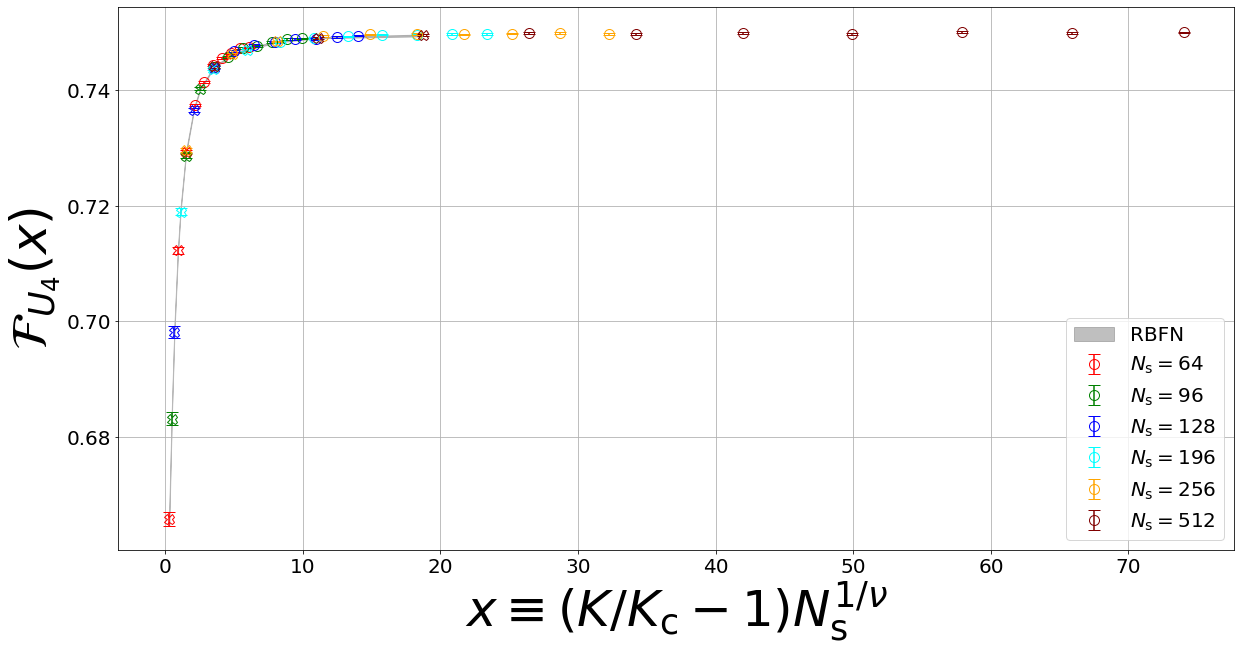

In [52]:
# Import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 10]
plt.close()

# Set figure information up
colors = {
    '48': 'magenta', '64': 'red', '96': 'green', '196': 'cyan',
    '128': 'blue', '256': 'orange', '512': 'maroon'
}

# Function that rescales input data
def rescale_x(b, l):
    return gv.mean(gv.exp(
        gv.log(gv.abs(b * fit_parameters['c'][0] - 1.)) + fit_parameters['c'][-1] * l
    ))

# Plot scaling function for neural network
xrs = list(data['x'])
xrs.sort(key = lambda x: rescale_x(*x))
RBFN = fit_fcn(*np.transpose(xrs), fit_parameters)
plt.fill_between(
    [*map(lambda x: rescale_x(*x), xrs)],
    gv.mean(RBFN) - gv.sdev(RBFN),
    gv.mean(RBFN) + gv.sdev(RBFN),
    color = 'grey', alpha = 0.5,
    label = 'RBFN'
)

# Plot raw data in fit
vol_labels = []
for data_in_fit, marker in zip([False, True], ['o', 'X']):
    plot_data, _ = example_tools.potts3_data('u', Kl, Kh, volumes, data_in_fit = data_in_fit)
    for b, l, y in zip(*np.transpose(plot_data['x']), plot_data['y']):
        # Rescaled x
        xr = rescale_x(b, l)

        # Arguments for errorbar
        errorbar_args = {
            'fmt': marker, 'capsize': 6.,
            'color': colors[str(int(round(np.exp(l))))],
            'markerfacecolor': 'none',
            'markeredgecolor': colors[str(int(round(np.exp(l))))],
            'markersize': 10.
        }

        # Check if we should add a label
        if l not in vol_labels:
            errorbar_args['label'] = '$N_{\\mathrm{s}}=' + str(int(round(np.exp(l)))) + '$'
            vol_labels.append(l)
        
        # Plot as errorbar
        if b > 1. / 0.99497:
            plt.errorbar(
                xr, gv.mean(y), gv.sdev(y), **errorbar_args
            )

plt.grid('on')
plt.legend(fontsize = 20.)
plt.gca().xaxis.set_tick_params(labelsize = 20.)
plt.gca().yaxis.set_tick_params(labelsize = 20.)
plt.xlabel('$x \\equiv (K/K_{\\mathrm{c}}-1)N_{\\mathrm{s}}^{1/\\nu}$', fontsize = 50.)
plt.ylabel('$\\mathcal{F}_{U_{4}}(x)$', fontsize = 50.)

# Curve collapse of the connected magnetic susceptiblity

Now that we've gotten our feet wet with the Binder cumulant, let's move on to the connected magnetic susceptibility $\chi$, defined as

$$\chi(K,N_{\mathrm{s}})=K N_{\mathrm{s}}^2 \big\langle (|M|-\langle |M| \rangle)^2 \big\rangle.$$

Within the vicinity of $K_{\mathrm{c}}$, the connected magnetic suscptibility scales as

$$\chi(K,N_{\mathrm{s}})= N_{\mathrm{s}}^{\gamma/\nu} \mathcal{F}_{\chi}\Big((K/K_{\mathrm{c}}-1)N_{\mathrm{s}}^{1/\nu}\Big).$$

The critical exponents $\gamma,\nu$ are related to the critical exponent of the wave function $\eta$ as $\gamma/\nu=2-\eta$. In the paper, $\eta$ is what we reported. Since I've already taken you through the analysis of the Binder cumulant step-by-step, let's throw the whole analysis together in one block. 

In [56]:
""" Get the data """
Kl, Kh = 1. / 0.99497, 1. / 0.975 # K = J/T, where T is the standard Ising temp.
volumes = ['128', '196', '256', '512'] # Ns values
data, starting_parameters = example_tools.potts3_data('sus', Kl, Kh, volumes)

""" Create the radial basis function network """
network_topology = {
    'lyr1': { # Hidden layer
        'in': 1, 'out': 2, # Dimension of input & output
        'activation': 'exp', # Exponential activation
    },
    'lyr2': { # Output layer
        'in': 2, 'out': 1,
        'activation': 'linear' # Linear activation
    }
}
neural_network = radial_basis.RadialBasisNeuralNetwork(network_topology)

""" Define the fit function """
def fit_fcn(b, l, p):
    return gv.log(np.ravel(
        neural_network.out(
            gv.log(gv.abs(b * p['c'][0] - 1.)) + p['c'][1] * l, p
        )
    )) + p['c'][1] * p['c'][-1] * l

""" Define a function that grabs the priors """
def get_priors(lmbda):
    # Initialize dictionary of priors
    prior = {}
    
    # Prior on critical parameters K_c & 1/nu
    prior['c'] = [gv.gvar('0.9(0.1)'), gv.gvar('1.3(0.5)'), gv.gvar('1.5(1.5)')]

    # Prior on the RBFN weights
    prior = neural_network.network_priors(
        prior_choice_weight = { # Prior for weights
            'lyr2': { # Only for output layer
                'prior_type': 'ridge_regression', # Type of prior
                'mean': 0., # Mean of zero
                'standard_deviation': lmbda # Width of lambda
            }
        }, 
        prior = prior # Take in already-specified prior dictionary and modify it
    )

    """ Return prior and p0 """
    return prior

""" Define function that creates SwissFit object """
def create_swissfit_object(lmbda):
    # Get priors and starting values for parameters
    prior = get_priors(lmbda)

    # Define a function that transforms the priors into log priors to force positivity on critical parameters
    log_priors = {'c': lambda x: gv.log(x)}

    # Create SwissFit fit object
    fitter = fit.SwissFit(
        udata = data, # Fit data; "data = data" is also acceptable - "udata" means "uncorrelated"
        uprior = prior, # Priors; "prior = prior" is also acceptable - "uprior" means "uncorrelated"
        p0 = create_swissfit_object.p0, # Starting values for parameters - chained for empirical Bayes
        fit_fcn = fit_fcn, # Fit function
        prior_transformation_fcn = log_priors # Transformation of prior "c" to "log(c)"
    )

    # Return SwissFit object
    return fitter

# Initialize fit parameters (functions in Python can have attributes)
create_swissfit_object.p0 = gv.mean(starting_parameters) # Parameters of first fit in empirical Bayes

""" Define function to do fit and grab marginal likelihood """
def do_fit(lmbda, alpha = 0.3 * 1e-1, T = 1., niter_success = 10, niter = 100000, return_fit = False):
    """ Set fitter and trust region reflective local optimizer up """
    # Create SwissFit fitter
    fitter = create_swissfit_object(lmbda)

    """ Create local optimizer """
    # Create trust region reflective local optimizer from SciPy - fitter will save reference to local_optimizer for basin hopping
    local_optimizer = scipy_least_squares.SciPyLeastSquares(
        fitter = fitter,
        optimizer_arguments = { # Reducing the tolerance reduces local optimization failures
            'ftol': 1e-5 if not return_fit else 1e-8,
            'gtol': 1e-5 if not return_fit else 1e-8,
            'xtol': 1e-5 if not return_fit else 1e-8
        }
    )

    """ Create basin hopping global optimizer object """
    # Basin hopping global optimizer object instantiation
    global_optimizer = scipy_basin_hopping.BasinHopping(
        fitter = fitter, # Fit function is the "calculate_residual" method of fitter object
        optimizer_arguments = {
            'niter_success': niter_success, # Number of times Theta_best must remain the same for algorithm to terminate
            'niter': niter, # Maximum number of iterations of basin hopping algorithm
            'T': T, # Temperature hyperparameter
            'take_step': example_tools.create_take_step(alpha, fitter, scipy_basin_hopping) # Custom step taking function
        }
    )

    """ Do fit & return marginal likelihood """
    # Do fit
    fitter(global_optimizer)

    # Save this set of parameters so that next fit can pick them up as its initial parameters
    create_swissfit_object.p0 = gv.mean(fitter.p)

    # Return marginal likelihood
    if return_fit: return fitter
    else: return -fitter.logml

""" Do empirical Bayes analysis """
# Set up empirical Bayes
emp_bayes_fit = single_parameter_surrogate.SingleParameterSurrogate(
    fcn = do_fit, # Our "do_fit" function that does the fit & calculates the marginal likelihood
    lb = 0.05, ub = 0.08, # Lower & upper bound on lambda
    n_points = 100, # Number of fits to perform
    spline_algorithm = 'steffen', # Use a monotonic spline
)

# Do empirical Bayes analysis
lambda_star = emp_bayes_fit().x[0]

# Fit data at lambda^{*} from empirical Bayes
fit_result = do_fit(lambda_star, return_fit = True)

# Print result of the fit
print(fit_result)

# Get critical parameters and print them
fit_parameters = fit_result.p
print('Tc, nu:', str(1. / fit_parameters['c'][0]) + ',', 1. / fit_parameters['c'][1], 2. - fit_parameters['c'][-1] * fit_parameters['c'][1])

/tmp/ipykernel_25972/2689113877.py:21: RuntimeWarning: invalid value encountered in log
  return gv.log(np.ravel(


Warning! ValueError in local optimization.

SwissFit: 🧀
   chi2/dof [dof] = 1.09 [15]   Q = 0.36   (Bayes) 
   chi2/dof [dof] = 1.41 [10]   Q = 0.17   (freq.) 
   AIC [k] = 34.07 [10]   logML = 63.85*

Parameters*:
     c
             1               0.995018(47)   [0.90(10)]
             2                  1.219(34)   [1.30(50)]
             3                  1.418(46)   [1.5(1.5)]
     lyr1.center
             1                   0.34(54)   [n/a]
             2                   6.66(67)   [n/a]
     lyr1.bandwidth
             1                  -0.36(30)   [n/a]
             2                 -0.081(20)   [n/a]
     lyr2.weight
             1                -0.0054(62)   [0.000(65)]
             2                  0.076(14)   [0.000(65)]
     lyr2.bias
             1                 0.0476(71)   [n/a]

Estimator:
   algorithm = SciPy basin hopping
   minimization_failures = 2
   nfev = 2789
   njev = 2247
   fun = 8.194513012619707
   message = ['success condition satisfied']
   n

Great, now that we're done, let's go ahead and see what the result of our fit looks like.

Text(0, 0.5, '$\\mathcal{F}_{\\chi}(x)$')

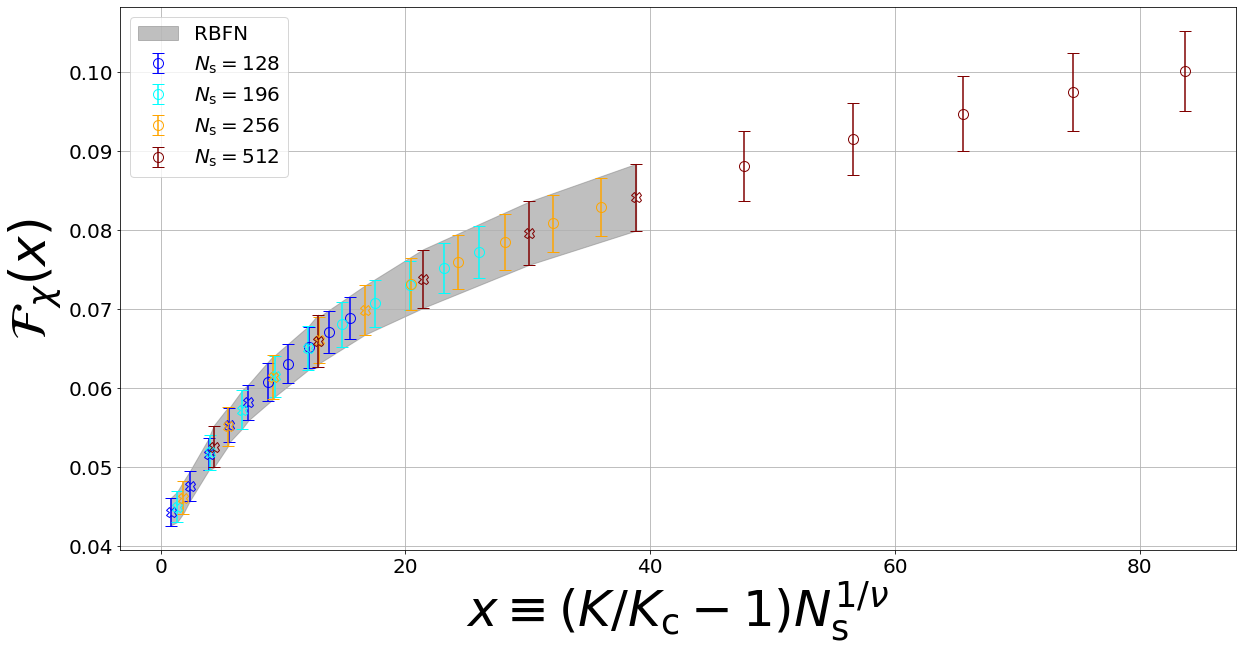

In [65]:
# Import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 10]
plt.close()

# Set figure information up
colors = {
    '48': 'magenta', '64': 'red', '96': 'green', '196': 'cyan',
    '128': 'blue', '256': 'orange', '512': 'maroon'
}

# Function that rescales input data
def rescale_x(b, l):
    return gv.mean(gv.exp(
        gv.log(gv.abs(b * fit_parameters['c'][0] - 1.)) + fit_parameters['c'][1] * l
    ))

# Plot scaling function for neural network
xrs = list(data['x'])
xrs.sort(key = lambda x: rescale_x(*x))
RBFN = fit_fcn(*np.transpose(xrs), fit_parameters)
RBFN -= fit_parameters['c'][1] * fit_parameters['c'][-1] * np.transpose(xrs)[-1]
RBFN = gv.exp(RBFN)
plt.fill_between(
    [*map(lambda x: rescale_x(*x), xrs)],
    gv.mean(RBFN) - gv.sdev(RBFN),
    gv.mean(RBFN) + gv.sdev(RBFN),
    color = 'grey', alpha = 0.5,
    label = 'RBFN'
)

# Plot raw data in fit
vol_labels = []
for data_in_fit, marker in zip([False, True], ['o', 'X']):
    if not data_in_fit:
        plot_data, _ = example_tools.potts3_data('sus', Kl, Kh, volumes, data_in_fit = data_in_fit)
    else: plot_data = fit_result.data
    for b, l, y in zip(*np.transpose(plot_data['x']), plot_data['y']):
        # Rescaled x
        xr = rescale_x(b, l)

        # Rescaled y
        y -= fit_parameters['c'][1] * fit_parameters['c'][-1] * l
        y = gv.exp(y)

        # Arguments for errorbar
        errorbar_args = {
            'fmt': marker, 'capsize': 6.,
            'color': colors[str(int(round(np.exp(l))))],
            'markerfacecolor': 'none',
            'markeredgecolor': colors[str(int(round(np.exp(l))))],
            'markersize': 10.
        }

        # Check if we should add a label
        if l not in vol_labels:
            errorbar_args['label'] = '$N_{\\mathrm{s}}=' + str(int(round(np.exp(l)))) + '$'
            vol_labels.append(l)
        
        # Plot as errorbar
        if b > 1. / 0.99497:
            plt.errorbar(
                xr, gv.mean(y), gv.sdev(y), **errorbar_args
            )

plt.grid('on')
plt.legend(fontsize = 20.)
plt.gca().xaxis.set_tick_params(labelsize = 20.)
plt.gca().yaxis.set_tick_params(labelsize = 20.)
plt.xlabel('$x \\equiv (K/K_{\\mathrm{c}}-1)N_{\\mathrm{s}}^{1/\\nu}$', fontsize = 50.)
plt.ylabel('$\\mathcal{F}_{\chi}(x)$', fontsize = 50.)